# Regression Modelling by Date

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import random
from datetime import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
trips = pd.read_csv("../CSVFiles/tripsStationHour.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips["Day"] = day
trips["Year"] = year
trips = trips.drop(columns=["DateEnd"])

# 243 - august 31st
# 304 - october 31st
trips_training = trips.loc[(trips["Day"] <= 243) & (trips["Year"] == 2011)]
trips_testing = trips.loc[(trips["Day"] > 243) & (trips["Day"] <= 304) & (trips["Year"] == 2011)]
trips_validation = trips.loc[(trips["Day"] > 304) & (trips["Year"] == 2011)]

## Regression

In [3]:
errors = {"Mean Absolute Error": [], "Mean Squared Error": [], "Mean Absolute Percentage Error": [], "Mean Percentage Error": []}

first_hour = trips_training.values[0][0]
first_day = trips_training.values[0][3]
first_year = trips_training.values[0][4]

accuracy = []

### Method 1
Input: c(t)

Output: c(t+1)

In [4]:
X = trips_training.drop(columns=["Count"])
y = trips_training["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year in trips_testing.values:
    prediction = lm.predict(np.array([[hour, station, day, year]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)
    
MAE = MAE / len(trips_testing)
MSE = MSE / len(trips_testing)
MAPE = MAPE/len(trips_testing)
MPE = MPE/len(trips_testing)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing.drop(columns=["Count"]), trips_testing["Count"]))

### Method 2
Input: c(t), c(t-1)

Output: c(t+1)

In [5]:
count_met2_train = 0
cnt_1day = []
for trip in trips_training.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if hour == first_hour and year == first_year and day == first_day:
        count_met2_train += 1
        continue

    hour -= 1
    if hour == -1:
        hour = 23
        day -= 1

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        cnt_1day.append(0)
    else:
        cnt_1day.append(df.values[0][2])

trips_method2 = trips_training[count_met2_train:].copy()
trips_method2["Count1"] = cnt_1day

count_met2_test = 0
cnt_1day = []
for trip in trips_testing.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if hour == first_hour and year == first_year and day == first_day:
        count_met2_test += 1
        continue

    hour -= 1
    if hour == -1:
        hour = 23
        day -= 1

    df = trips_testing.loc[(trips_testing["Hour"] == hour) & (trips_testing["Day"] == day) & (trips_testing["Year"] == year) & (trips_testing["StationEnd"] == station)]

    if df.empty:
        cnt_1day.append(0)
    else:
        cnt_1day.append(df.values[0][2])

trips_testing2 = trips_testing[count_met2_test:].copy()
trips_testing2["Count1"] = cnt_1day

count_met2_val = 0
cnt_1day = []
for trip in trips_validation.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if hour == first_hour and year == first_year and day == first_day:
        count_met2_val += 1
        continue

    hour -= 1
    if hour == -1:
        hour = 23
        day -= 1

    df = trips_validation.loc[(trips_validation["Hour"] == hour) & (trips_validation["Day"] == day) & (trips_validation["Year"] == year) & (trips_validation["StationEnd"] == station)]

    if df.empty:
        cnt_1day.append(0)
    else:
        cnt_1day.append(df.values[0][2])

trips_validation2 = trips_validation[count_met2_val:].copy()
trips_validation2["Count1"] = cnt_1day

X = trips_method2.drop(columns=["Count"])
y = trips_method2["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year, count_1 in trips_testing2.values:
    prediction = lm.predict(np.array([[hour, station, day, year, count_1]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)

MAE = MAE / len(trips_testing2)
MSE = MSE / len(trips_testing2)
MAPE = MAPE / len(trips_testing2)
MPE = MPE / len(trips_testing2)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing2.drop(columns=["Count"]), trips_testing2["Count"]))

### Method 3
Input: c(t), c(t-1), c(t-1semana)

Output: c(t+1)

In [6]:
count_met3_train = 0
cnt_1week = []
for trip in trips_training.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 7:
        count_met3_train += 1
        continue

    day -= 7

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        cnt_1week.append(0)
    else:
        cnt_1week.append(df.values[0][2])

trips_method3 = trips_method2[count_met3_train-count_met2_train:].copy()
trips_method3["Count1week"] = cnt_1week

count_met3_test = 0
cnt_1week = []
for trip in trips_testing.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 7:
        count_met3_test += 1
        continue

    day -= 7

    df = trips_testing.loc[(trips_testing["Hour"] == hour) & (trips_testing["Day"] == day) & (trips_testing["Year"] == year) & (trips_testing["StationEnd"] == station)]

    if df.empty:
        cnt_1week.append(0)
    else:
        cnt_1week.append(df.values[0][2])

trips_testing3 = trips_testing2[count_met3_test-count_met2_test:].copy()
trips_testing3["Count1week"] = cnt_1week

count_met3_val = 0
cnt_1day = []
for trip in trips_validation.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 7:
        count_met3_val += 1
        continue

    day -= 7

    df = trips_validation.loc[(trips_validation["Hour"] == hour) & (trips_validation["Day"] == day) & (trips_validation["Year"] == year) & (trips_validation["StationEnd"] == station)]

    if df.empty:
        cnt_1day.append(0)
    else:
        cnt_1day.append(df.values[0][2])

trips_validation3 = trips_validation2[count_met3_val-count_met2_val:].copy()
trips_validation3["Count1week"] = cnt_1day

X = trips_method3.drop(columns=["Count"])
y = trips_method3["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year, count_1, count_1sem in trips_testing3.values:
    prediction = lm.predict(np.array([[hour, station, day, year, count_1, count_1sem]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)

MAE = MAE / len(trips_testing3)
MSE = MSE / len(trips_testing3)
MAPE = MAPE / len(trips_testing3)
MPE = MPE / len(trips_testing3)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing3.drop(columns=["Count"]), trips_testing3["Count"]))

### Method 4
Input: c(t), c(t-1), c(t-1semana), c(t-2semana)

Output: c(t+1)

In [7]:
count_met4_train = 0
cnt_2week = []
for trip in trips_training.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 14:
        count_met4_train += 1
        continue

    day -= 14

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        cnt_2week.append(0)
    else:
        cnt_2week.append(df.values[0][2])

trips_method4 = trips_method3[count_met4_train-count_met3_train:].copy()
trips_method4["Count2week"] = cnt_2week

count_met4_test = 0
cnt_2week = []
for trip in trips_testing.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 14:
        count_met4_test += 1
        continue

    day -= 14

    df = trips_testing.loc[(trips_testing["Hour"] == hour) & (trips_testing["Day"] == day) & (trips_testing["Year"] == year) & (trips_testing["StationEnd"] == station)]

    if df.empty:
        cnt_2week.append(0)
    else:
        cnt_2week.append(df.values[0][2])

trips_testing4 = trips_testing3[count_met4_test-count_met3_test:].copy()
trips_testing4["Count2week"] = cnt_2week

count_met4_val = 0
cnt_1day = []
for trip in trips_validation.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 14:
        count_met4_val += 1
        continue

    day -= 14

    df = trips_validation.loc[(trips_validation["Hour"] == hour) & (trips_validation["Day"] == day) & (trips_validation["Year"] == year) & (trips_validation["StationEnd"] == station)]

    if df.empty:
        cnt_1day.append(0)
    else:
        cnt_1day.append(df.values[0][2])

trips_validation4 = trips_validation3[count_met4_val-count_met3_val:].copy()
trips_validation4["Count2week"] = cnt_1day

X = trips_method4.drop(columns=["Count"])
y = trips_method4["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year, count_1, count_1sem, count_2sem in trips_testing4.values:
    prediction = lm.predict(np.array([[hour, station, day, year, count_1, count_1sem, count_2sem]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)

MAE = MAE / len(trips_testing4)
MSE = MSE / len(trips_testing4)
MAPE = MAPE / len(trips_testing4)
MPE = MPE / len(trips_testing4)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing4.drop(columns=["Count"]), trips_testing4["Count"]))

### Method 5
Input: c(t), c(t-1), c(t-1semana), c(t-2semana), c(t-3semana)

Output: c(t+1)

In [8]:
count_met5_train = 0
cnt_3week = []
for trip in trips_training.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 21:
        count_met5_train += 1
        continue

    day -= 21

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        cnt_3week.append(0)
    else:
        cnt_3week.append(df.values[0][2])

trips_method5 = trips_method4[count_met5_train-count_met4_train:].copy()
trips_method5["Count3week"] = cnt_3week

count_met5_test = 0
cnt_3week = []
for trip in trips_testing.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 21:
        count_met5_test += 1
        continue

    day -= 21

    df = trips_testing.loc[(trips_testing["Hour"] == hour) & (trips_testing["Day"] == day) & (trips_testing["Year"] == year) & (trips_testing["StationEnd"] == station)]

    if df.empty:
        cnt_3week.append(0)
    else:
        cnt_3week.append(df.values[0][2])

trips_testing5 = trips_testing4[count_met5_test-count_met4_test:].copy()
trips_testing5["Count3week"] = cnt_3week

count_met5_val = 0
cnt_1day = []
for trip in trips_validation.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 21:
        count_met5_val += 1
        continue

    day -= 21

    df = trips_validation.loc[(trips_validation["Hour"] == hour) & (trips_validation["Day"] == day) & (trips_validation["Year"] == year) & (trips_validation["StationEnd"] == station)]

    if df.empty:
        cnt_1day.append(0)
    else:
        cnt_1day.append(df.values[0][2])

trips_validation5 = trips_validation4[count_met5_val-count_met4_val:].copy()
trips_validation5["Count3week"] = cnt_1day

X = trips_method5.drop(columns=["Count"])
y = trips_method5["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year, count_1, count_1sem, count_2sem, count_3sem in trips_testing5.values:
    prediction = lm.predict(np.array([[hour, station, day, year, count_1, count_1sem, count_2sem, count_3sem]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)

MAE = MAE / len(trips_testing5)
MSE = MSE / len(trips_testing5)
MAPE = MAPE/len(trips_testing5)
MPE = MPE/len(trips_testing5)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing5.drop(columns=["Count"]), trips_testing5["Count"]))

### Method 6
Input: c(t), c(t-1), c(t-1semana), c(t-2semana), c(t-3semana), c(t-4semana)

Output: c(t+1)

In [9]:
count_met6_train = 0
cnt_4week = []
for trip in trips_training.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 28:
        count_met6_train += 1
        continue

    day -= 28

    df = trips_training.loc[(trips_training["Hour"] == hour) & (trips_training["Day"] == day) & (trips_training["Year"] == year) & (trips_training["StationEnd"] == station)]

    if df.empty:
        cnt_4week.append(0)
    else:
        cnt_4week.append(df.values[0][2])

trips_method6 = trips_method5[count_met6_train-count_met5_train:].copy()
trips_method6["Count4week"] = cnt_4week

count_met6_test = 0
cnt_4week = []
for trip in trips_testing.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 28:
        count_met6_test += 1
        continue

    day -= 28

    df = trips_testing.loc[(trips_testing["Hour"] == hour) & (trips_testing["Day"] == day) & (trips_testing["Year"] == year) & (trips_testing["StationEnd"] == station)]

    if df.empty:
        cnt_4week.append(0)
    else:
        cnt_4week.append(df.values[0][2])

trips_testing6 = trips_testing5[count_met6_test-count_met5_test:].copy()
trips_testing6["Count4week"] = cnt_4week

count_met6_val = 0
cnt_1day = []
for trip in trips_validation.values:
    hour = trip[0]
    station = trip[1]
    day = trip[3]
    year = trip[4]

    if day < first_day + 28:
        count_met6_val += 1
        continue

    day -= 28

    df = trips_validation.loc[(trips_validation["Hour"] == hour) & (trips_validation["Day"] == day) & (trips_validation["Year"] == year) & (trips_validation["StationEnd"] == station)]

    if df.empty:
        cnt_1day.append(0)
    else:
        cnt_1day.append(df.values[0][2])

trips_validation6 = trips_validation5[count_met6_val-count_met5_val:].copy()
trips_validation6["Count4week"] = cnt_1day

X = trips_method6.drop(columns=["Count"])
y = trips_method6["Count"]

lm = linear_model.LinearRegression().fit(X, y)

MAE = 0
MSE = 0
MAPE = 0
MPE = 0
for hour, station, count, day, year, count_1, count_1sem, count_2sem, count_3sem, count_4sem in trips_testing6.values:
    prediction = lm.predict(np.array([[hour, station, day, year, count_1, count_1sem, count_2sem, count_3sem, count_4sem]]))
    MAE += abs(count - prediction)
    MSE += (count - prediction)**2
    MAPE += (abs((count - prediction))/count)
    MPE += ((count - prediction)/count)

MAE = MAE / len(trips_testing6)
MSE = MSE / len(trips_testing6)
MAPE = MAPE/len(trips_testing6)
MPE = MPE/len(trips_testing6)

errors["Mean Absolute Error"].append(MAE)
errors["Mean Squared Error"].append(MSE)
errors["Mean Absolute Percentage Error"].append(MAPE)
errors["Mean Percentage Error"].append(MPE)

accuracy.append(lm.score(trips_testing6.drop(columns=["Count"]), trips_testing6["Count"]))

## Graphs

Text(0.5, 0, 'Methods')

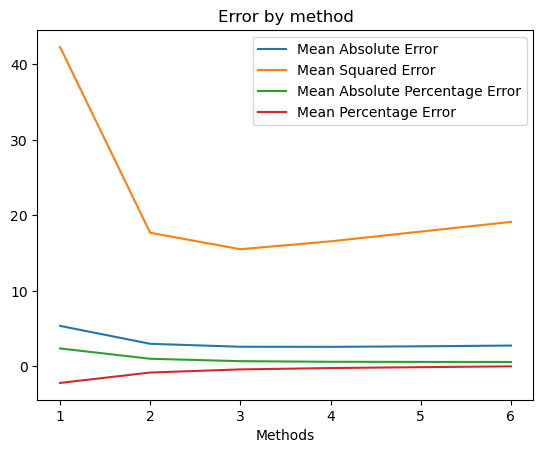

In [10]:
legend = []
for errorType, error in errors.items():
    plt.plot(list(range(1,len(error)+1)), error)
    legend.append(f"{errorType}")
plt.legend(legend)
plt.title("Error by method")
plt.xlabel("Methods")

Text(0.5, 0, 'Methods')

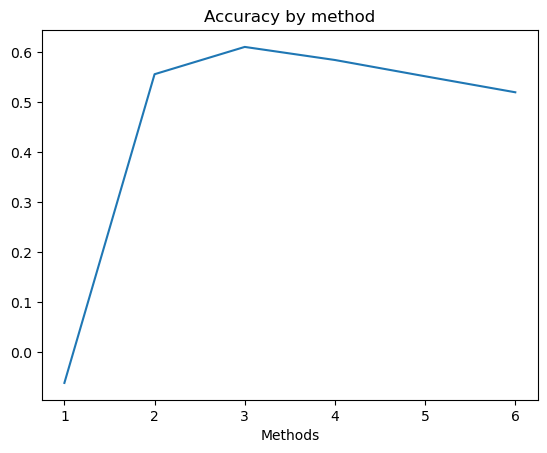

In [11]:
plt.plot(list(range(1,len(accuracy)+1)), accuracy)
plt.title("Accuracy by method")
plt.xlabel("Methods")

In [12]:
trips_method3.to_csv("../DateDatasets/training.csv")
trips_testing3.to_csv("../DateDatasets/testing.csv")
trips_validation3.to_csv("../DateDatasets/validation.csv")